<a href="https://colab.research.google.com/github/ppkgtmm/sentiment/blob/main/EDA_amazon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import math
import matplotlib.pyplot as plt
import re
import nltk
from unicodedata import normalize
import collections

In [3]:
nltk.download('punkt')
from nltk import word_tokenize

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [4]:
cols = ['text', 'target']
decode_map = {0: 'negative', 1: 'positive'}

## Read data
#### column description
1. text : review text
2. target : polarity of review
    
    * 0 : negative
    * 1 : positive


In [ ]:
data = pd.read_csv('/content/drive/MyDrive/sentiment/data/data.csv')[cols]
data.sample(5)

,text,target
65541,"Pure, Unadulterated Drivel....: Not only that,...",0
213749,"Feel good music, ya gotta at least tap your to...",1
324204,Pretty Small Bags for Big Ponds: I have to adm...,0
192626,On the GO GO GO Boy LOVE THIS!!: I just got th...,1
337422,Terrific movie: Lemmon and MacLaine are great ...,1


## EDA

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 360000 entries, 0 to 359999
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    360000 non-null  object
 1   target  360000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 5.5+ MB


In [ ]:
data.isnull().any()

text      False
target    False
dtype: bool

In [ ]:
# ValueError: No objects to concatenate
# duplicates = pd.concat(rows for _, rows in data.groupby('text') \
#                        if len(rows) > 1)
# duplicates

In [ ]:
target_dist = data.groupby('target').count().reset_index()
target_dist['proportion'] = target_dist['text'] / sum(list(target_dist['text']))
target_dist

,target,text,proportion
0,0,180000,0.5
1,1,180000,0.5


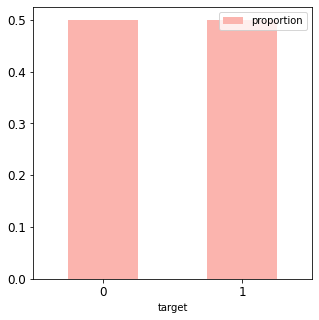

In [ ]:
target_dist.plot(x='target', y='proportion', kind='bar', rot=0, \
                 colormap='Pastel1', fontsize=12, figsize=(5,5))

In [ ]:
copy = data.copy()
copy['word_count'] = copy['text'].apply(lambda x: len(x.split(' ')))

In [ ]:
def avg_word_length(text):
    words = text.split(' ')
    length = [len(w) for w in words]
    return math.ceil(sum(length) / len(length))

copy['avg_word_length'] = copy['text'].apply(avg_word_length)

In [ ]:
copy.head(5)

,text,target,word_count,avg_word_length
0,A nice listen: I have always beed a huge stars...,1,135,4
1,I am Very satisfied with this order: It was a ...,1,26,5
2,Christmas Present: I got this for my son for C...,1,79,5
3,Prob works for some doors but not ours: We hav...,0,134,5
4,"can you say 'rip off'?: These bulbs, while ill...",0,176,5


In [ ]:
copy.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
target,360000.0,0.500000,0.500001,0.0,0.0,0.5,1.0,1.0
word_count,360000.0,78.471886,42.831131,2.0,42.0,70.0,108.0,223.0
avg_word_length,360000.0,5.032367,0.530537,2.0,5.0,5.0,5.0,97.0


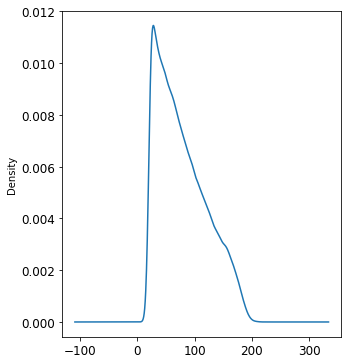

In [ ]:
copy.word_count.plot(kind='kde', fontsize=12, figsize=(5,6))

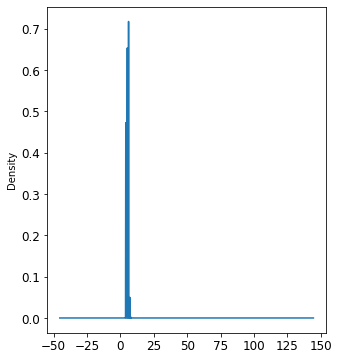

In [ ]:
copy.avg_word_length.plot(kind='kde', fontsize=12, figsize=(5,6))

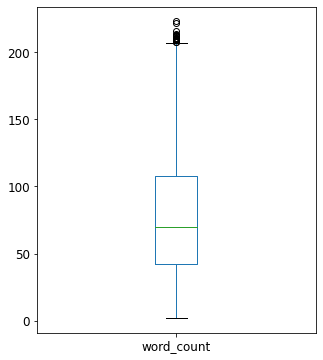

In [ ]:
copy.word_count.plot(kind='box', fontsize=12, figsize=(5,6))

In [8]:
reserved_words = ["EMAIL", "NUMBER", "MENTION", "URL"]
token_dict = {
            "ca": "can",
            "wo": "will",
            "sha": "shall",
            "'ve": "have",
            "'ll": "will",
            "'m": "am",
            "n't": "not",
            "'re": "are",
        }
word_dict = {
            "cant": "can not",
            "couldnt": "could not",
            "wont": "will not",
            "pls": "please",
            "plz": "please",
            "youre": "you are",
            "theyre": "they are",
            "ive": "I have",
            "havent": "have not",
            "hasnt": "has not",
            "hadnt": "had not",
            "im": "I am",
            "didnt": "did not",
            "dont": "do not",
            "doesnt": "does not",
            "gotta": "got to",
            "wanna": "want to",
            "gonna": "going to",
            "wannabe": "want to be",
            "cannot": "can not",
        }

In [9]:
def substitute(doc):
        doc = re.sub(r"<br />", " ", doc)
        doc = re.sub(r"\S+@\S+", " EMAIL ", doc)
        doc = re.sub(r"@\S+", " MENTION ", doc)
        doc = re.sub(r"https?:\S+|http?:\S+", " URL ", doc)
        doc = re.sub(r"(\d+\-\d+)|\d+", " NUMBER ", doc)
        doc = re.sub(r"[^A-Za-z']", " ", doc)

        return doc

def expand(token):
        if token in reserved_words:
            return token
        token = token.lower()
        if token.lower().strip() == "let's":
            return "let us"

        if token.lower().strip() == "'twas":
            return "it was"

        if word_dict.get(token, None):
            return word_dict.get(token)

        tokens = word_tokenize(token)
        if len(tokens) == 1:
            return word_dict.get(tokens[0], tokens[0])
        for i in range(len(tokens)):
            tokens[i] = token_dict.get(tokens[i], tokens[i])

        return " ".join(tokens)

def preprocess(doc):
        doc = normalize('NFD',doc).encode('ascii', 'ignore').decode('utf-8')
        doc = substitute(doc)
        tokens = doc.split()
        doc = " ".join([expand(w) for w in tokens])

        tokens = doc.split()
        tokens = [word for word in tokens if word.isalpha()]

        tokens = [
            word.lower() if word not in reserved_words else word for word in tokens
        ]

        return " ".join(tokens)

In [10]:
preprocess("😂 @mama124 Im gonna enter http:bit.ly.12673/ab \
for 30th time :| don't know why cant i České Budějovic á Ś cé")

'MENTION i am going to enter URL for NUMBER th time do not know why can not i ceske budejovic a s ce'

In [ ]:
%%time 
for i in range(len(list(copy['text']))):
  copy['text'].loc[i] = preprocess(copy['text'].loc[i])

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


CPU times: user 52min 17s, sys: 1.06 s, total: 52min 18s
Wall time: 52min 18s


In [ ]:
copy[cols].to_csv('/content/drive/MyDrive/sentiment/data/data_preprocessed2.csv')

In [ ]:
def avg_word_length(text):
    words = text.split(' ')
    length = [len(w) for w in words]
    return math.ceil(sum(length) / len(length))

copy['word_count'] = copy['text'].apply(lambda x: len(x.split(' ')))
copy['avg_word_length'] = copy['text'].apply(avg_word_length)

In [ ]:
copy.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
target,360000.0,0.500000,0.500001,0.0,0.0,0.5,1.0,1.0
word_count,360000.0,80.454903,44.037829,3.0,43.0,72.0,111.0,245.0
avg_word_length,360000.0,4.792322,0.510167,2.0,4.0,5.0,5.0,15.0


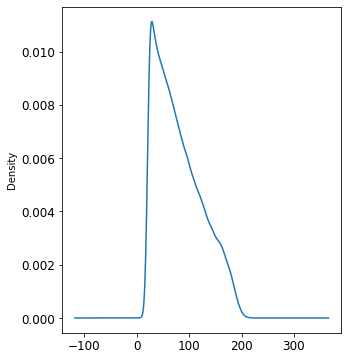

In [ ]:
copy.word_count.plot(kind='kde', fontsize=12, figsize=(5,6))

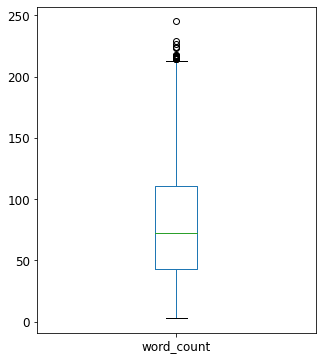

In [ ]:
copy.word_count.plot(kind='box', fontsize=12, figsize=(5,6))

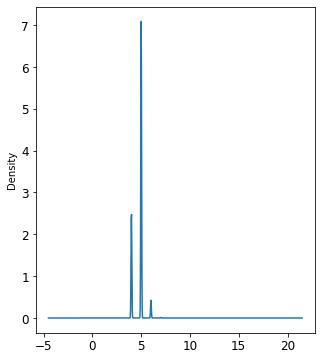

In [ ]:
copy.avg_word_length.plot(kind='kde', fontsize=12, figsize=(5,6))

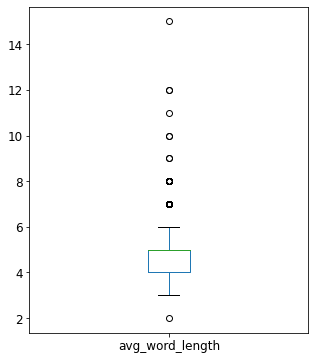

In [ ]:
copy.avg_word_length.plot(kind='box', fontsize=12, figsize=(5,6))

In [ ]:
word_counts = collections.Counter(" ".join(copy['text']).split())

In [ ]:
count_df = pd.DataFrame(word_counts.most_common(20))
count_df.columns = ['word', 'count']
count_df['proportion'] = count_df['count'] / sum(list(count_df['count']))
count_df.head()

,word,count,proportion
0,the,1435635,0.147026
1,i,837721,0.085792
2,and,771538,0.079014
3,a,723410,0.074086
4,to,697957,0.071479


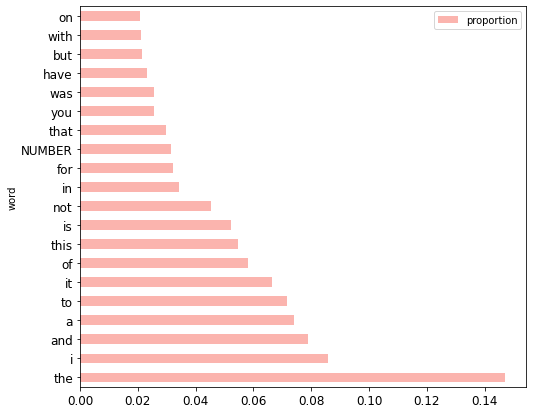

In [ ]:
count_df.plot(kind='barh', x='word', y='proportion', rot=0, \
                 colormap='Pastel1', fontsize=12, figsize=(8,7))

In [ ]:
preprocessed = pd.read_csv(
    '/content/drive/MyDrive/sentiment/data/data_preprocessed2.csv'
    )[cols]
preprocessed.sample(5)

,text,target
189572,serious design flaws three years ago i purchas...,0
96328,a miss soderbergh movies are usually hit or mi...,0
305723,can not do without it i have very sensitive sk...,1
133602,great knife this is the best folding knife i h...,1
51098,let the music melt your troubles away i absolu...,1


In [ ]:
preprocessed.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
target,360000.0,0.5,0.500001,0.0,0.0,0.5,1.0,1.0


In [ ]:
preprocessed[['text']].describe().transpose()

,count,unique,top,freq
text,360000,359986,why they skip so much of the book wuthering he...,2


In [ ]:
duplicates = pd.concat(g for _, g in preprocessed.groupby("text") if len(g) > 1)

In [ ]:
duplicates.head()

,text,target
115827,absolutely beautiful talk of angels is truly a...,1
343762,absolutely beautiful talk of angels is truly a...,1
194677,decidedly mediocre i am a big fan of the new d...,0
291121,decidedly mediocre i am a big fan of the new d...,0
112462,disappointing bridge software i had hoped for ...,0


In [ ]:
duplicates.groupby('text').agg('nunique').reset_index() \
 .sort_values('target') \
 .head()

,text,target
0,absolutely beautiful talk of angels is truly a...,1
1,decidedly mediocre i am a big fan of the new d...,1
2,disappointing bridge software i had hoped for ...,1
3,do not be fooled by the names or the other rev...,1
4,easy to install after spending over an hour tr...,1


In [ ]:
preprocessed = preprocessed.drop_duplicates(
    subset=['text'], 
    keep='last'
  )

In [ ]:
preprocessed.groupby('target').describe()

text                                                                
         count  unique                                                top freq
target                                                                        
0       179990  179990  what a piti concert and interviews mixed toget...    1
1       179996  179996  you will either like it or hate it not great b...    1

In [ ]:
preprocessed.to_csv('/content/drive/MyDrive/sentiment/data/data_preprocessed.csv')

## Test set

In [5]:
test = pd.read_csv('/content/drive/MyDrive/sentiment/data/test_data.csv')[cols]
test.sample(5)

,text,target
4802,Classic Horror: This is horror with the requir...,1
12542,Calvin original fragrance is the best found la...,1
8336,Could something really be so bad??: Watching m...,0
9145,Great speaker- get it: It's small but the soun...,1
15170,Begginer content written for an expert: This h...,0


In [11]:
%%time 
test['text'] = test['text'].apply(preprocess)

CPU times: user 1min 44s, sys: 37.3 ms, total: 1min 44s
Wall time: 1min 44s


In [14]:
test.groupby('text').count().reset_index().sort_values('target', ascending=False)

,text,target
0,NUMBER NUMBER NUMBER stars i found out about t...,1
13330,one of the best movies ever my kids love this ...,1
13337,one of the best sports movies ever a movie wit...,1
13336,one of the best space based game ever this gam...,1
13335,one of the best roger waters stanley clarke pa...,1
...,...,...
6666,get toner cartridges ha forget it printer work...,1
6665,get this one in the past i may have been able ...,1
6664,get this book this book has the clear ring of ...,1
6663,get this book and start brewing i got this boo...,1


In [17]:
test[['text']].describe().transpose()

,count,unique,top,freq
text,20000,20000,great movie very powerful and artistic movie b...,1


In [15]:
test.to_csv('/content/drive/MyDrive/sentiment/data/test_data_preprocessed.csv')